In [1]:
import torch
from transformers import CLIPModel, CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, UNet2DConditionModel

#NOTE: Last tested working diffusers version is diffusers==1.18.2, pytorch v2

/home/wlaud1001/miniconda3/envs/diffusers/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
#Init CLIP tokenizer and model
model_path_clip = "openai/clip-vit-large-patch14"
clip_tokenizer = CLIPTokenizer.from_pretrained(model_path_clip)
clip_model = CLIPModel.from_pretrained(model_path_clip, torch_dtype=torch.float16)
clip = clip_model.text_model

#Init diffusion model
auth_token = True #Replace this with huggingface auth token as a string if model is not already downloaded
model_path_diffusion = "CompVis/stable-diffusion-v1-4"
unet = UNet2DConditionModel.from_pretrained(model_path_diffusion, subfolder="unet", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)
vae = AutoencoderKL.from_pretrained(model_path_diffusion, subfolder="vae", use_auth_token=auth_token, revision="fp16", torch_dtype=torch.float16)

#Move to GPU
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="0"

device = "cuda"
unet.to(device)
vae.to(device)
clip.to(device)
print("Loaded all models")

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.


Loaded all models


In [24]:
import numpy as np
import random
from PIL import Image
from diffusers import LMSDiscreteScheduler
from tqdm.auto import tqdm
from torch import autocast
from difflib import SequenceMatcher


def init_attention_weights(weight_tuples):
    tokens_length = clip_tokenizer.model_max_length
    weights = torch.ones(tokens_length)
    
    for i, w in weight_tuples:
        if i < tokens_length and i >= 0:
            weights[i] = w
    
    
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn2" in name:
            module.processor.last_attn_slice_weights = weights.to(device)
        if module_name == "Attention" and "attn1" in name:
            module.processor.last_attn_slice_weights = None


def init_attention_edit(tokens, tokens_edit):
    tokens_length = clip_tokenizer.model_max_length
    mask = torch.zeros(tokens_length)
    indices_target = torch.arange(tokens_length, dtype=torch.long)
    indices = torch.zeros(tokens_length, dtype=torch.long)

    tokens = tokens.input_ids.numpy()[0]
    tokens_edit = tokens_edit.input_ids.numpy()[0]

    for name, a0, a1, b0, b1 in SequenceMatcher(None, tokens, tokens_edit).get_opcodes():
        if b0 < tokens_length:
            if name == "equal" or (name == "replace" and a1-a0 == b1-b0):
                mask[b0:b1] = 1
                indices[b0:b1] = indices_target[a0:a1]

    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn2" in name:
            module.processor.last_attn_slice_mask = mask.to(device)
            module.processor.last_attn_slice_indices = indices.to(device)
        if module_name == "Attention" and "attn1" in name:
            module.processor.last_attn_slice_mask = None
            module.processor.last_attn_slice_indices = None


def use_last_tokens_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn2" in name:
            module.processor.use_last_attn_slice = use
            
def use_last_tokens_attention_weights(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn2" in name:
            module.processor.use_last_attn_weights = use
            
def use_last_self_attention(use=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn1" in name:
            module.processor.use_last_attn_slice = use
            
def save_last_tokens_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn2" in name:
            module.processor.save_last_attn_slice = save
            
def save_last_self_attention(save=True):
    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention" and "attn1" in name:
            module.processor.save_last_attn_slice = save


In [25]:
def init_attention_func():
    #ORIGINAL SOURCE CODE: https://github.com/huggingface/diffusers/blob/91ddd2a25b848df0fa1262d4f1cd98c7ccb87750/src/diffusers/models/attention.py#L276

    class NewAttnProcessor:
        r"""
        Default processor for performing attention-related computations.
        """
    
        def __call__(
            self,
            attn,
            hidden_states,
            encoder_hidden_states=None,
            attention_mask=None,
            temb=None,
        ):
            residual = hidden_states
    
            if attn.spatial_norm is not None:
                hidden_states = attn.spatial_norm(hidden_states, temb)
    
            input_ndim = hidden_states.ndim
    
            if input_ndim == 4:
                batch_size, channel, height, width = hidden_states.shape
                hidden_states = hidden_states.view(batch_size, channel, height * width).transpose(1, 2)
    
            batch_size, sequence_length, _ = (
                hidden_states.shape if encoder_hidden_states is None else encoder_hidden_states.shape
            )
            attention_mask = attn.prepare_attention_mask(attention_mask, sequence_length, batch_size)
    
            if attn.group_norm is not None:
                hidden_states = attn.group_norm(hidden_states.transpose(1, 2)).transpose(1, 2)
    
            query = attn.to_q(hidden_states)
    
            if encoder_hidden_states is None:
                encoder_hidden_states = hidden_states
            elif attn.norm_cross:
                encoder_hidden_states = attn.norm_encoder_hidden_states(encoder_hidden_states)
    
            key = attn.to_k(encoder_hidden_states)
            value = attn.to_v(encoder_hidden_states)
    
            query = attn.head_to_batch_dim(query)
            key = attn.head_to_batch_dim(key)
            value = attn.head_to_batch_dim(value)
    
            attn_slice = attn.get_attention_scores(query, key, attention_mask)

            if self.use_last_attn_slice:
                if self.last_attn_slice_mask is not None:
                    new_attn_slice = torch.index_select(self.last_attn_slice, -1, self.last_attn_slice_indices)
                    attn_slice = attn_slice * (1 - self.last_attn_slice_mask) + new_attn_slice * self.last_attn_slice_mask
                else:
                    attn_slice = self.last_attn_slice
    
                self.use_last_attn_slice = False
    
            if self.save_last_attn_slice:
                self.last_attn_slice = attn_slice
                self.save_last_attn_slice = False
    
            if self.use_last_attn_weights and self.last_attn_slice_weights is not None:
                attn_slice = attn_slice * self.last_attn_slice_weights
                self.use_last_attn_weights = False
            
            hidden_states = torch.bmm(attn_slice, value)
            hidden_states = attn.batch_to_head_dim(hidden_states)
    
            # linear proj
            hidden_states = attn.to_out[0](hidden_states)
            # dropout
            hidden_states = attn.to_out[1](hidden_states)
    
            if input_ndim == 4:
                hidden_states = hidden_states.transpose(-1, -2).reshape(batch_size, channel, height, width)
    
            if attn.residual_connection:
                hidden_states = hidden_states + residual
    
            hidden_states = hidden_states / attn.rescale_output_factor
    
            return hidden_states


    for name, module in unet.named_modules():
        module_name = type(module).__name__
        if module_name == "Attention":
            module.processor = NewAttnProcessor()
            module.processor.last_attn_slice = None
            module.processor.use_last_attn_slice = False
            module.processor.use_last_attn_weights = False
            module.processor.save_last_attn_slice = False


In [37]:
@torch.no_grad()
def stablediffusion(prompt="", prompt_edit=None, prompt_edit_token_weights=[], prompt_edit_tokens_start=0.0, prompt_edit_tokens_end=1.0, prompt_edit_spatial_start=0.0, prompt_edit_spatial_end=1.0, guidance_scale=7.5, steps=50, seed=None, width=512, height=512, init_image=None, init_image_strength=0.5):
    #Change size to multiple of 64 to prevent size mismatches inside model
    width = width - width % 64
    height = height - height % 64
    
    #If seed is None, randomly select seed from 0 to 2^32-1
    if seed is None: seed = random.randrange(2**32 - 1)
    generator = torch.cuda.manual_seed(seed)
    
    #Set inference timesteps to scheduler
    scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)
    scheduler.set_timesteps(steps)
    
    #Preprocess image if it exists (img2img)
    if init_image is not None:
        #Resize and transpose for numpy b h w c -> torch b c h w
        init_image = init_image.resize((width, height), resample=Image.Resampling.LANCZOS)
        init_image = np.array(init_image).astype(np.float32) / 255.0 * 2.0 - 1.0
        init_image = torch.from_numpy(init_image[np.newaxis, ...].transpose(0, 3, 1, 2))
        
        #If there is alpha channel, composite alpha for white, as the diffusion model does not support alpha channel
        if init_image.shape[1] > 3:
            init_image = init_image[:, :3] * init_image[:, 3:] + (1 - init_image[:, 3:])
            
        #Move image to GPU
        init_image = init_image.to(device)
        
        #Encode image
        with autocast(device):
            init_latent = vae.encode(init_image).latent_dist.sample(generator=generator) * 0.18215
            
        t_start = steps - int(steps * init_image_strength)
            
    else:
        init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
        t_start = 0
    
    #Generate random normal noise
    noise = torch.randn(init_latent.shape, generator=generator, device=device)
    #latent = noise * scheduler.init_noise_sigma
    latent = scheduler.add_noise(init_latent, noise, torch.tensor([scheduler.timesteps[t_start]], device=device)).to(device)
    
    #Process clip
    with autocast(device):
        tokens_unconditional = clip_tokenizer("", padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_unconditional = clip(tokens_unconditional.input_ids.to(device)).last_hidden_state

        tokens_conditional = clip_tokenizer(prompt, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
        embedding_conditional = clip(tokens_conditional.input_ids.to(device)).last_hidden_state
        
        init_attention_func()
        init_attention_weights(prompt_edit_token_weights)
            
        #Process prompt editing
        if prompt_edit is not None:
            tokens_conditional_edit = clip_tokenizer(prompt_edit, padding="max_length", max_length=clip_tokenizer.model_max_length, truncation=True, return_tensors="pt", return_overflowing_tokens=True)
            embedding_conditional_edit = clip(tokens_conditional_edit.input_ids.to(device)).last_hidden_state
            
            init_attention_edit(tokens_conditional, tokens_conditional_edit)
            
 
        timesteps = scheduler.timesteps[t_start:]
        
        for i, t in tqdm(enumerate(timesteps), total=len(timesteps)):
            t_index = t_start + i

            #sigma = scheduler.sigmas[t_index]
            latent_model_input = latent
            latent_model_input = scheduler.scale_model_input(latent_model_input, t)

            #Predict the unconditional noise residual
            noise_pred_uncond = unet(latent_model_input, t, encoder_hidden_states=embedding_unconditional).sample
            
            #Prepare the Cross-Attention layers
            if prompt_edit is not None:
                save_last_tokens_attention()
                save_last_self_attention()
            else:
                #Use weights on non-edited prompt when edit is None
                use_last_tokens_attention_weights()
                
            #Predict the conditional noise residual and save the cross-attention layer activations
            noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional).sample
            
            #Edit the Cross-Attention layer activations
            if prompt_edit is not None:
                t_scale = t / scheduler.num_train_timesteps
                if t_scale >= prompt_edit_tokens_start and t_scale <= prompt_edit_tokens_end:
                    use_last_tokens_attention()
                if t_scale >= prompt_edit_spatial_start and t_scale <= prompt_edit_spatial_end:
                    use_last_self_attention()
                    
                #Use weights on edited prompt
                use_last_tokens_attention_weights()

                #Predict the edited conditional noise residual using the cross-attention masks
                noise_pred_cond = unet(latent_model_input, t, encoder_hidden_states=embedding_conditional_edit).sample
                
            #Perform guidance
            noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_cond - noise_pred_uncond)
            # print(scheduler.timesteps)
            # print(t_index)
            latent = scheduler.step(noise_pred, t, latent).prev_sample
            # latent = scheduler.step(noise_pred, scheduler.timesteps[t_index], latent).prev_sample

        #scale and decode the image latents with vae
        latent = latent / 0.18215
        image = vae.decode(latent.to(vae.dtype)).sample

    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.cpu().permute(0, 2, 3, 1).numpy()
    image = (image[0] * 255).round().astype("uint8")
    return Image.fromarray(image)


<ipython-input-37-db98874ea170>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
100%|██████████| 50/50 [00:04<00:00, 11.65it/s]


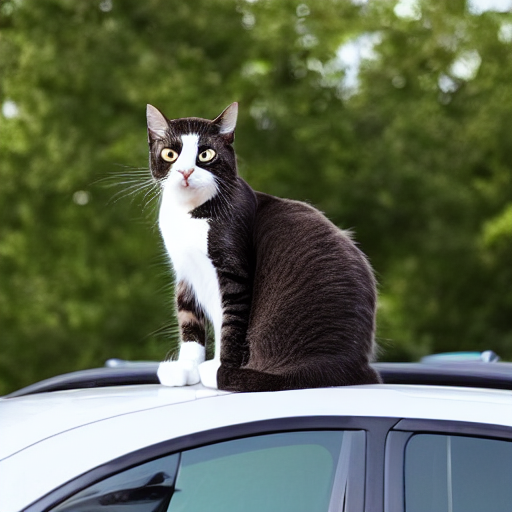

In [38]:
stablediffusion("a cat sitting on a car", prompt_edit_spatial_start=1, seed=248396402679)

<ipython-input-37-db98874ea170>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


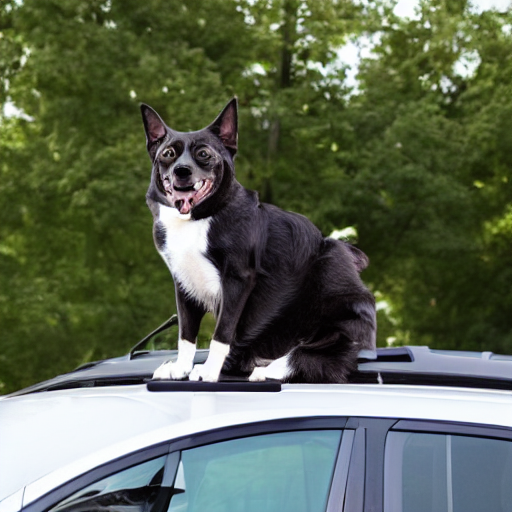

In [39]:
stablediffusion("a cat sitting on a car", "a smilling dog sitting on a car", prompt_edit_spatial_start=0.7, seed=248396402679)

<ipython-input-37-db98874ea170>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
100%|██████████| 50/50 [00:06<00:00,  7.74it/s]


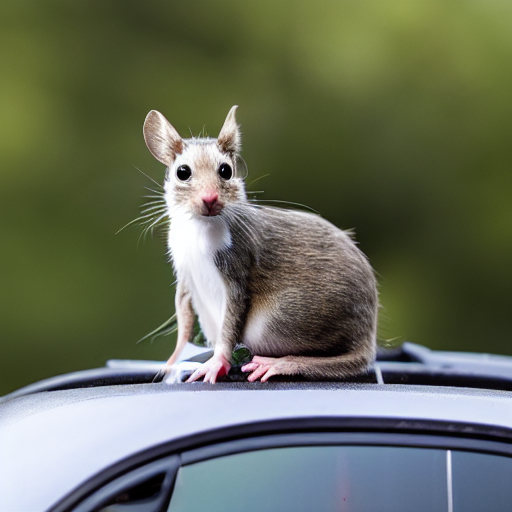

In [40]:
stablediffusion("a cat sitting on a car", "a mouse sitting on a car", prompt_edit_spatial_start=0.5, seed=248396402679)

<ipython-input-37-db98874ea170>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
100%|██████████| 50/50 [00:07<00:00,  6.73it/s]


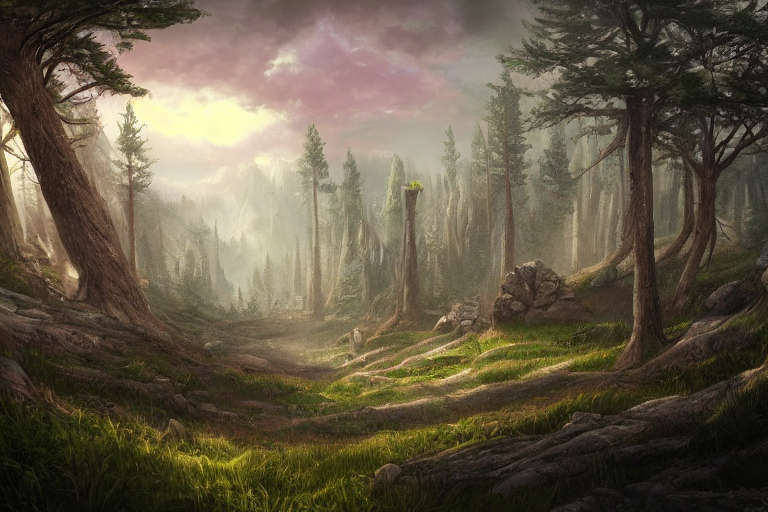

In [41]:
stablediffusion("A fantasy landscape with a pine forest, trending on artstation", seed=2483964025, width=768)

<ipython-input-37-db98874ea170>:36: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  init_latent = torch.zeros((1, unet.in_channels, height // 8, width // 8), device=device)
100%|██████████| 50/50 [00:07<00:00,  6.79it/s]


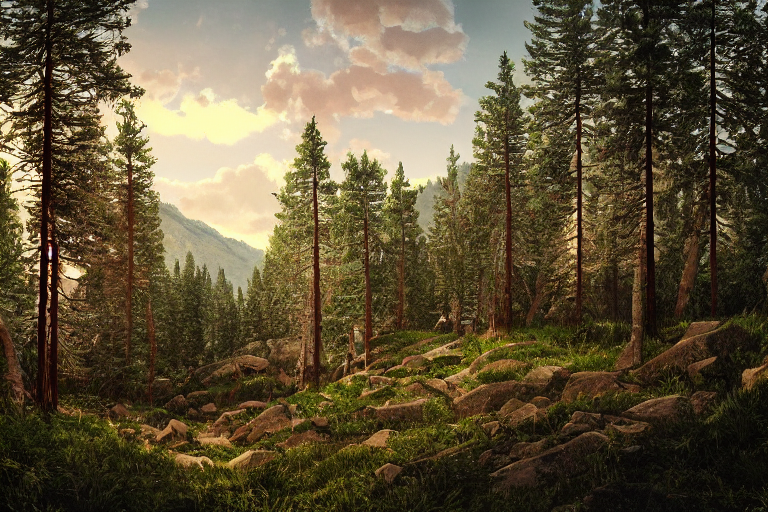

In [42]:
#Remove fantasy
stablediffusion("A fantasy landscape with a pine forest, trending on artstation", prompt_edit_token_weights=[(2, -8)], seed=2483964025, width=768)